[link competition](https://www.kaggle.com/competitions/titanic/data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/Titanic"

/content/drive/MyDrive/Colab Notebooks/Titanic


# I.Import Package

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier

# II.Load dataset

In [150]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


-Dataset có 12 columns, "Survived" là biến mục tiêu (phân loại 0 và 1)

- PassengerID: đánh thứ tự ID hành khách (category)
- Pclass: lớp vé (ticket class) - 1 = 1st, 2 = 2nd, 3 = 3rd
- Name: tên hành khách
- Sex: Giới tính (category)
- Age: Độ tuổi (numeric)
- SibSp: Có anh chị em trên tàu không (1 = có, 0 = không)
- Parch: Có bố mẹ trên tàu không (1 = có, 0 = không)
- Ticket: Số hiệu vé 
- Fare: giá vé hành khách (numeric)
- Cabin: Số hiệu cabin
- Embarked: Cảng lên tàu (C = Cherbourg, Q = Queenstown, S = Southampton)

# III.Thống kê mô tả

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


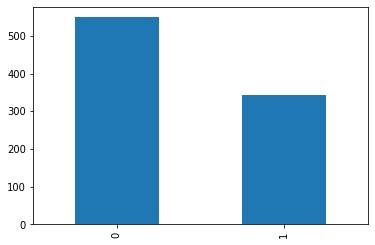

In [7]:
df['Survived'].value_counts().plot(kind='bar')

# IV.Preprosessing

In [11]:
# Data Exploring : Missing Values
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        missinginfo = {"ColumnName" : col, "TotalMissingVals" : sum_miss_val, "PercentMissing" : percent_miss_val}
        miss_df = miss_df.append(missinginfo, ignore_index = True)
    
    miss_df = miss_df[miss_df["PercentMissing"] > 0.0]
    miss_df = miss_df.reset_index(drop = True)
    return miss_df

In [12]:
find_missing_percent(df)

,ColumnName,TotalMissingVals,PercentMissing
0,Age,177.0,19.87
1,Cabin,687.0,77.10
2,Embarked,2.0,0.22


-3 Age, Cabin, Embarked có missing value, "Cabin" có tỉ lệ missing rất lớn lên đến 77.10%

-Dùng KNN Imputer khắc phục missing value

In [17]:
# Data Cleansing and Partition (Data Imputation - KNN Imputation)
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

def knn_imputation_numeric(train_numeric):
    imputed_train = imputer.fit_transform(train_numeric)
    train_numeric_imp = pd.DataFrame(imputed_train, columns = train_numeric.columns, index= train_numeric.index)
    return train_numeric_imp

def knn_imputation_categoric(train_categoric):
    ordinal_dict={}
    for col in train_categoric:
        '''Ordinal encode train data'''
        ordinal_dict[col] = OrdinalEncoder()
        nn_vals = np.array(train_categoric[col][train_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].fit_transform(nn_vals)).reshape(-1,)
        train_categoric[col].loc[train_categoric[col].notnull()] = nn_vals_arr

    imputed_train = imputer.fit_transform(train_categoric)
    train_categoric_imp = pd.DataFrame(imputed_train, columns =train_categoric.columns,index = train_categoric.index).astype(int)
    
    '''Inverse Transform'''
    for col in train_categoric_imp.columns:
        oe = ordinal_dict[col]
        train_arr= np.array(train_categoric_imp[col]).reshape(-1,1)
        train_categoric_imp[col] = oe.inverse_transform(train_arr)
        
    return train_categoric_imp

In [151]:
data_numeric = df[['Age']]
data_categoric = df[['Cabin', 'Embarked']]

In [152]:
data_numeric_imp  = knn_imputation_numeric(data_numeric)
data_categoric_imp = knn_imputation_categoric(data_categoric)
df_copy = df
df_copy.drop(['Age', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500
...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,0,0,211536,13.0000
887,888,1,1,"Graham, Miss. Margaret Edith",female,0,0,112053,30.0000
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.4500
889,890,1,1,"Behr, Mr. Karl Howell",male,0,0,111369,30.0000


In [153]:
data_knn_imp = pd.concat([data_numeric_imp, data_categoric_imp], axis = 1)
data_knn_imp

,Age,Cabin,Embarked
0,22.000000,D20,S
1,38.000000,C85,C
2,26.000000,D20,S
3,35.000000,C123,S
4,35.000000,D20,S
...,...,...,...
886,27.000000,D20,S
887,19.000000,B42,S
888,29.699118,D20,S
889,26.000000,C148,C


In [154]:
df_copy = pd.concat([data_knn_imp, df_copy], axis = 1)

In [155]:
df_copy['Age'] = round(df_copy['Age'], 1)
df_copy

,Age,Cabin,Embarked,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
0,22.0,D20,S,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500
1,38.0,C85,C,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833
2,26.0,D20,S,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250
3,35.0,C123,S,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000
4,35.0,D20,S,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,D20,S,887,0,2,"Montvila, Rev. Juozas",male,0,0,211536,13.0000
887,19.0,B42,S,888,1,1,"Graham, Miss. Margaret Edith",female,0,0,112053,30.0000
888,29.7,D20,S,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.4500
889,26.0,C148,C,890,1,1,"Behr, Mr. Karl Howell",male,0,0,111369,30.0000


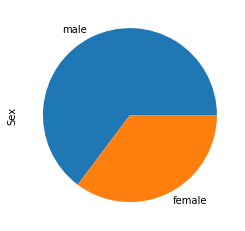

In [49]:
df_copy['Sex'].value_counts().plot(kind='pie')

# V.Train/test split

In [156]:
# categoric_cols = [['Cabin','Embarked', 'Name', 'Sex', 'Ticket']]
# One hot encoding
df_copy = df_copy.drop('PassengerId', axis=1)
df_copy = df_copy.drop('Ticket', axis=1)
df_copy = df_copy.drop('Name', axis=1)
df_copy = df_copy.drop('Cabin', axis=1)

df_copy = pd.get_dummies(df_copy)

In [109]:
df_copy

,Age,Survived,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,22.0,0,3,1,0,7.2500,0,0,1,0,1
1,38.0,1,1,1,0,71.2833,1,0,0,1,0
2,26.0,1,3,0,0,7.9250,0,0,1,1,0
3,35.0,1,1,1,0,53.1000,0,0,1,1,0
4,35.0,0,3,0,0,8.0500,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,2,0,0,13.0000,0,0,1,0,1
887,19.0,1,1,0,0,30.0000,0,0,1,1,0
888,29.7,0,3,1,2,23.4500,0,0,1,1,0
889,26.0,1,1,0,0,30.0000,1,0,0,0,1


In [157]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_copy[['Age']] = scaler.fit_transform(df_copy[['Age']])
df_copy[['Fare']] = scaler.fit_transform(df_copy[['Fare']])

In [158]:
X = df_copy.drop('Survived', axis=1)
y = df_copy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

print(X_train.shape)
print(X_test.shape)

(623, 10)
(268, 10)


# VI.Modelling

In [159]:
# lg = LogisticRegression()
xgb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [160]:
clf = xgb.fit(X_train, y_train)

In [161]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy on train: ', accuracy_score(y_train, y_train_pred))
print('Accuracy on test: ', accuracy_score(y_test, y_test_pred))

Accuracy on train:  0.869983948635634
Accuracy on test:  0.7873134328358209


# VII.Predicting on test

In [162]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [73]:
find_missing_percent(test)

,ColumnName,TotalMissingVals,PercentMissing
0,Age,86.0,20.57
1,Fare,1.0,0.24
2,Cabin,327.0,78.23


In [163]:
data_numeric = test[['Age']]
data_categoric = test[['Cabin', 'Fare']]
data_numeric_imp  = knn_imputation_numeric(data_numeric)
data_categoric_imp = knn_imputation_categoric(data_categoric)
df_copy = test
df_copy.drop(['Age', 'Cabin', 'Fare'], axis=1, inplace=True)
df_copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked
0,892,3,"Kelly, Mr. James",male,0,0,330911,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,S
2,894,2,"Myles, Mr. Thomas Francis",male,0,0,240276,Q
3,895,3,"Wirz, Mr. Albert",male,0,0,315154,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,3101298,S
...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,0,0,A.5. 3236,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,0,0,PC 17758,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,0,0,SOTON/O.Q. 3101262,S
416,1308,3,"Ware, Mr. Frederick",male,0,0,359309,S


In [164]:
data_knn_imp = pd.concat([data_numeric_imp, data_categoric_imp], axis = 1)
df_copy = pd.concat([data_knn_imp, df_copy], axis = 1)

In [165]:
df_copy

,Age,Cabin,Fare,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked
0,34.50000,D43,7.8292,892,3,"Kelly, Mr. James",male,0,0,330911,Q
1,47.00000,D43,7.0000,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,S
2,62.00000,E45,9.6875,894,2,"Myles, Mr. Thomas Francis",male,0,0,240276,Q
3,27.00000,F,8.6625,895,3,"Wirz, Mr. Albert",male,0,0,315154,S
4,22.00000,E45,12.2875,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,3101298,S
...,...,...,...,...,...,...,...,...,...,...,...
413,30.27259,F E57,8.0500,1305,3,"Spector, Mr. Woolf",male,0,0,A.5. 3236,S
414,39.00000,C105,108.9000,1306,1,"Oliva y Ocana, Dona. Fermina",female,0,0,PC 17758,C
415,38.50000,D43,7.2500,1307,3,"Saether, Mr. Simon Sivertsen",male,0,0,SOTON/O.Q. 3101262,S
416,30.27259,F E57,8.0500,1308,3,"Ware, Mr. Frederick",male,0,0,359309,S


In [166]:
df_copy = df_copy.drop('PassengerId', axis=1)
df_copy = df_copy.drop('Ticket', axis=1)
df_copy = df_copy.drop('Name', axis=1)
df_copy = df_copy.drop('Cabin', axis=1)

df_copy = pd.get_dummies(df_copy)

scaler = MinMaxScaler()
df_copy[['Age']] = scaler.fit_transform(df_copy[['Age']])
df_copy[['Fare']] = scaler.fit_transform(df_copy[['Fare']])

In [135]:
df_copy

,Age,Fare,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.452723,0.015282,3,0,0,0,1,0,1,0
1,0.617566,0.013663,3,1,0,1,0,0,0,1
2,0.815377,0.018909,2,0,0,0,1,0,1,0
3,0.353818,0.016908,3,0,0,0,1,0,0,1
4,0.287881,0.023984,3,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,0.396975,0.015713,3,0,0,0,1,0,0,1
414,0.512066,0.212559,1,0,0,1,0,1,0,0
415,0.505473,0.014151,3,0,0,0,1,0,0,1
416,0.396975,0.015713,3,0,0,0,1,0,0,1


In [129]:
df_copy['Fare'].isnull().value_counts()

False    417
True       1
Name: Fare, dtype: int64

In [167]:
y_test_pred = clf.predict(df_copy)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [169]:
ind_col['Survived'] = y_test_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [170]:
# ind_col = test[['PassengerId']]
ind_col

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [171]:
ind_col.to_csv('out.csv', index=False)